In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [515]:
def get_joined_df(loans, results):
    return loans.merge(results, left_on='id', right_on='test_ids')

In [599]:
def get_performance(loans, res):
    grades = sorted(loans.grade.unique())
    sub_grades = ['%s%i' % (g,i) for g in grades for i in range(1,6)]
    loans['sub_grade'] = pd.Series([sub_grades[i] for i in np.where(loans.loc[:, 'sub_grade_A1':'sub_grade_G5'])[1]], 
                                  index=loans.index.copy())

    historical_by_subgrade = pd.DataFrame(index = sub_grades)
    historical_by_subgrade['default'] = 1-loans.groupby('sub_grade').loan_status_binary.sum()/loans.sub_grade.value_counts()
    historical_by_subgrade['int_rate'] = loans.groupby('sub_grade').int_rate.mean()
    historical_by_subgrade['dollar_percent'] = loans.groupby('sub_grade').loan_amnt.sum()/loans.loan_amnt.sum()
    historical_by_subgrade['n_percent'] = loans.sub_grade.value_counts()/len(loans)
    historical_by_subgrade['int_rate_surv'] = loans[loans.loan_status_binary == 1].groupby('sub_grade').int_rate.mean()
    
    betas = sorted(res.keys())

    pfs = {}
    pf_dists = {}
    
    for b in betas:
        r = res[b]
        pool = get_joined_df(loans, r)
        rec_msk = pool.y_test_pred == 1
        rec = pool[rec_msk]
        n = len(rec)
        stats = {
            'default': 1-rec.loan_status_binary.sum()/n,
            'n_percent': 1.0*n/len(pool),
            'dollar_percent': rec.loan_amnt.sum()/pool.loan_amnt.sum(),
            'int_rate': rec.int_rate.mean(),
            'int_rate_surv': rec[rec.loan_status_binary == 1].int_rate.mean()
        }

        pfs[b] = stats
        pf_dists[b] = rec.grade.value_counts()/len(rec)

    pf_df = pd.DataFrame(pfs).T
    beta_for_sub = historical_by_subgrade.default.map(lambda x: np.argmin(np.abs(x-pf_df.default)))
    historical_by_subgrade['beta'] = beta_for_sub
    
    return pf_df, historical_by_subgrade, pf_dists

In [543]:
all_loans_fname = "loans_ALL.pkl"
all_loans = pd.read_pickle(all_loans_fname)

In [600]:
models = ['MLR', 'SVM']
fnames = {
    'grade': "../output/results/predictions_%s_by_grade.pkl",
    'pooled': "../output/results/predictions_%s_pooled.pkl"
}

perf = {}

for mname in models:
    perf_m = {}
    for k, fn in fnames.items():
        with open(fn % mname) as f:
            res = pickle.load(f)
            pf, lc, dist = get_performance(all_loans, res)
            perf_m[k] = {
                'pf': pf,
                'lc': lc,
                'dist': dist
            }
    perf[mname] = perf_m

In [582]:
def get_comparison_df(perf, pooled = False):
    mtype = 'pooled' if pooled else 'grade'
    return pd.merge(perf[mtype]['lc'],perf[mtype]['pf'], left_on='beta', right_index=True, suffixes=['_LC', '_PF'])

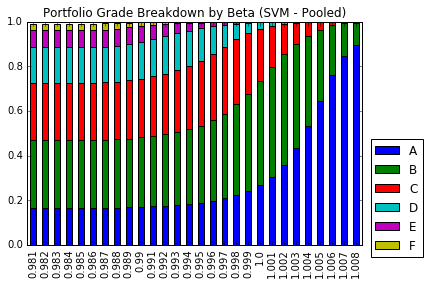

In [636]:
r = perf['SVM']['pooled']

pd.DataFrame(r['dist']).T.loc[.981:1.008,:'F'].plot(kind='bar', stacked=True, title='Portfolio Grade Breakdown by Beta (SVM - Pooled)', ylim=(0,1)).legend(bbox_to_anchor=(1.2, 0.5))
plt.savefig('pf_grade_dist_svm_pooled.png')

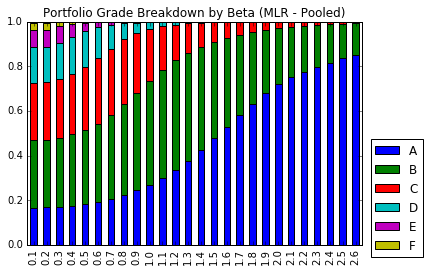

In [637]:
r = perf['MLR']['pooled']

pd.DataFrame(r['dist']).T.loc[:2.6,:'F'].plot(kind='bar', stacked=True, title='Portfolio Grade Breakdown by Beta (MLR - Pooled)', ylim=(0,1)).legend(bbox_to_anchor=(1.2, 0.5))
plt.savefig('pf_grade_dist_mlr_pooled.png')

In [634]:
get_comparison_df(perf['MLR'], pooled=True).loc[:]

default_LC  int_rate_LC  dollar_percent_LC  n_percent_LC  \
A1    0.031753     0.059752           0.019384      0.023421   
A2    0.044146     0.065328           0.020094      0.024831   
A3    0.053526     0.074016           0.025503      0.028690   
A4    0.071094     0.077714           0.040467      0.044355   
A5    0.078990     0.086114           0.044755      0.047258   
B1    0.100222     0.097509           0.042716      0.047895   
B2    0.110849     0.107179           0.053467      0.057331   
B3    0.124233     0.116558           0.065471      0.072418   
B4    0.139495     0.124235           0.063023      0.067091   
B5    0.148873     0.129651           0.051394      0.056766   
C1    0.162810     0.135981           0.054585      0.059055   
C2    0.173059     0.142288           0.053344      0.056535   
C3    0.201301     0.147496           0.049117      0.049754   
C4    0.209554     0.153138           0.048279      0.046804   
C5    0.219880     0.160015           0.045275      0.043288   
D1    0.232396     0.166653           0.038778      0.038816   
D2    0.246992     0.172080           0.035006      0.035721   
D3    0.248221     0.176411           0.032298      0.031225   
D4    0.277843     0.181626           0.032253      0.029009   
D5    0.279149     0.187796           0.028169      0.024064   
E1    0.287178     0.191342           0.023162      0.018380   
E2    0.318903     0.198310           0.022891      0.017960   
E3    0.316570     0.203653           0.019562      0.014980   
E4    0.342660     0.210353           0.018218      0.013290   
E5    0.346055     0.216726           0.015317      0.011262   
F1    0.340345     0.224159           0.012396      0.008953   
F2    0.349502     0.228905           0.010280      0.007268   
F3    0.396752     0.234447           0.008570      0.006244   
F4    0.423529     0.237440           0.007238      0.004926   
F5    0.434783     0.241117           0.005966      0.003887   
G1    0.417230     0.243903           0.004475      0.002859   
G2    0.387244     0.244786           0.003222      0.002120   
G3    0.402730     0.245421           0.002181      0.001415   
G4    0.334746     0.238293           0.001768      0.001140   
G5    0.404878     0.238802           0.001375      0.000990   

    int_rate_surv_LC  beta  default_PF  dollar_percent_PF  int_rate_PF  \
A1          0.059743   2.6    0.032318           0.068116     0.073640   
A2          0.065325   2.2    0.043704           0.120351     0.078656   
A3          0.073970   2.0    0.052996           0.157787     0.081972   
A4          0.077683   1.6    0.071904           0.266341     0.091892   
A5          0.086036   1.4    0.080657           0.342174     0.097929   
B1          0.097422   1.1    0.100513           0.494033     0.108086   
B2          0.107084   1.0    0.108812           0.553132     0.111699   
B3          0.116439   0.8    0.127530           0.676020     0.118829   
B4          0.124033   0.7    0.137160           0.741312     0.122808   
B5          0.129410   0.6    0.146520           0.806054     0.126506   
C1          0.135791   0.4    0.162377           0.916679     0.132637   
C2          0.141985   0.2    0.174652           0.995439     0.137404   
C3          0.147012   0.1    0.175329           0.999931     0.137708   
C4          0.152644   0.1    0.175329           0.999931     0.137708   
C5          0.159486   0.1    0.175329           0.999931     0.137708   
D1          0.166141   0.1    0.175329           0.999931     0.137708   
D2          0.171679   0.1    0.175329           0.999931     0.137708   
D3          0.175901   0.1    0.175329           0.999931     0.137708   
D4          0.181073   0.1    0.175329           0.999931     0.137708   
D5          0.187277   0.1    0.175329           0.999931     0.137708   
E1          0.190813   0.1    0.175329           0.999931     0.137708   
E2          0.197459   0.1    0.175329           0.999931     0.137708 

In [630]:
get_comparison_df(perf['SVM'], pooled=True).loc[:]

default_LC  int_rate_LC  dollar_percent_LC  n_percent_LC  \
A1    0.031753     0.059752           0.019384      0.023421   
A2    0.044146     0.065328           0.020094      0.024831   
A3    0.053526     0.074016           0.025503      0.028690   
A4    0.071094     0.077714           0.040467      0.044355   
A5    0.078990     0.086114           0.044755      0.047258   
B1    0.100222     0.097509           0.042716      0.047895   
B2    0.110849     0.107179           0.053467      0.057331   
B3    0.124233     0.116558           0.065471      0.072418   
B4    0.139495     0.124235           0.063023      0.067091   
B5    0.148873     0.129651           0.051394      0.056766   
C1    0.162810     0.135981           0.054585      0.059055   
C2    0.173059     0.142288           0.053344      0.056535   
C3    0.201301     0.147496           0.049117      0.049754   
C4    0.209554     0.153138           0.048279      0.046804   
C5    0.219880     0.160015           0.045275      0.043288   
D1    0.232396     0.166653           0.038778      0.038816   
D2    0.246992     0.172080           0.035006      0.035721   
D3    0.248221     0.176411           0.032298      0.031225   
D4    0.277843     0.181626           0.032253      0.029009   
D5    0.279149     0.187796           0.028169      0.024064   
E1    0.287178     0.191342           0.023162      0.018380   
E2    0.318903     0.198310           0.022891      0.017960   
E3    0.316570     0.203653           0.019562      0.014980   
E4    0.342660     0.210353           0.018218      0.013290   
E5    0.346055     0.216726           0.015317      0.011262   
F1    0.340345     0.224159           0.012396      0.008953   
F2    0.349502     0.228905           0.010280      0.007268   
F3    0.396752     0.234447           0.008570      0.006244   
F4    0.423529     0.237440           0.007238      0.004926   
F5    0.434783     0.241117           0.005966      0.003887   
G1    0.417230     0.243903           0.004475      0.002859   
G2    0.387244     0.244786           0.003222      0.002120   
G3    0.402730     0.245421           0.002181      0.001415   
G4    0.334746     0.238293           0.001768      0.001140   
G5    0.404878     0.238802           0.001375      0.000990   

    int_rate_surv_LC   beta  default_PF  dollar_percent_PF  int_rate_PF  \
A1          0.059743  1.008    0.032194           0.050936     0.070797   
A2          0.065325  1.007    0.039686           0.086064     0.074681   
A3          0.073970  1.006    0.052327           0.131190     0.079724   
A4          0.077683  1.004    0.072027           0.246873     0.091266   
A5          0.086036  1.003    0.080912           0.312881     0.096986   
B1          0.097422  1.001    0.100372           0.460645     0.107261   
B2          0.107084  1.000    0.110392           0.532385     0.111538   
B3          0.116439  0.998    0.128261           0.658291     0.118657   
B4          0.124033  0.997    0.136999           0.716323     0.122038   
B5          0.129410  0.995    0.149763           0.813051     0.127335   
C1          0.135791  0.992    0.162518           0.909553     0.132433   
C2          0.141985  0.988    0.172882           0.985270     0.136847   
C3          0.147012  0.981    0.175324           1.000000     0.137711   
C4          0.152644  0.981    0.175324           1.000000     0.137711   
C5          0.159486  0.981    0.175324           1.000000     0.137711   
D1          0.166141  0.981    0.175324           1.000000     0.137711   
D2          0.171679  0.981    0.175324           1.000000     0.137711   
D3          0.175901  0.981    0.175324           1.000000     0.137711   
D4          0.181073  0.981    0.175324           1.000000     0.137711   
D5          0.187277  0.981    0.175324           1.000000     0.137711   
E1          0.190813  0.981    0.175324           1.000000     0.137711   
E2          0.197459  0.981    0.175324          